In [1]:
# Carregando as bibliotecas
import pandas as pd
import numpy as np
import yfinance as yf
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier
import sklearn.metrics as metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression

import warnings
warnings.simplefilter(action='ignore')

sns.set(style = 'white')
get_ipython().run_line_magic('matplotlib', 'inline')

In [4]:
# Função que constroi variáveis que serão explicadas
def constroi_alvo(df, p):
    
    # Construção dos alvos
    p = 1

    # criação do Retorno no período p
    df["Retorno"] = np.log(df["Adj Close"]).diff(p)

    # criação da colula Alvo obtido com o retorno no período p
    df["Alvo"] = df["Retorno"].shift(-p)

    # Variação em Pontos do alvo (d+1 - d)
    df["Pontos"] = (df["Adj Close"].shift(-p) - df["Adj Close"])

    # Criação do Allvo Binário
    df["Alvo_Bin"] = np.where(df1["Alvo"] > 0, 1, -1)

    return df
    
# Função que cria variáveis 
def cria_variaveis(df):

    df["high_low"] = np.where((df["Retorno"] > df["Retorno"].shift(1)), 1, 0)
    df["high_low_p1"] = df["high_low"].shift(1).fillna(0).apply(int)
    df["R_r"] = np.where((df["high_low"] == 0) & (df["high_low_p1"] == 0), 1, 0)

    # Desvio Padrão de 5 dias
    df["std5"] = df["Retorno"].rolling(5).std()

    # Desvio Padrão de 10 dias
    df["std10"] = df["Retorno"].rolling(10).std()

    # Desvio Padrão de 15 dias
    df["std15"] = df["Retorno"].rolling(15).std()

    # Média Móvel de 5 dias
    df["mm_5"] = df["Retorno"].rolling(5).mean()

    # Média Móvel de 10 dias
    df["mm_10"] = df["Retorno"].rolling(10).mean()

    # Média Móvel de 15 dias
    df["mm_15"] = df["Retorno"].rolling(15).mean()

    # Proporção do corpo do candle em relação ao range do dia
    df["prop"] = (df["Close"] - df["Open"]) / (df["High"] - df["Low"])

    # Direção do dia atual
    df1["dir_d"] = np.where(df1["Close"] > df1["Open"], 1, 0)
    
    # Direção do D-1
    df["dir_d-1"] = df["dir_d"].shift(1)

    # Direção do D-2
    df1["dir_d-2"] = df["dir_d"].shift(2)

    # Direção do D-3
    df["dir_d-3"] = df["dir_d"].shift(3)

    # Média Móvel do std de 5 dias
    df["mm_std5"] = df["std5"].rolling(15).mean()

    # Média Móvel do std de 10 dias
    df["mm_std10"] = df["std10"].rolling(15).mean()

    # Média Móvel do std de 15 dias
    df["mm_std15"] = df["std15"].rolling(15).mean()
    
    # Zscore de 5 dias
    df["zscore_5"] = (df["Retorno"] - df["mm_5"])/ df1["std5"]

    # Zscore de 10 dias
    df["zscore_10"] = (df["Retorno"] - df["mm_10"])/ df1["std10"]

    # Zscore de 15 dias
    df["zscore_15"] = (df["Retorno"] - df["mm_15"])/ df1["std15"]

    # RSL std5
    df["rsl_std5"] = (df["std5"] / df["mm_std5"])-1
    
    # RSL std10
    df["rsl_std10"] = (df["std10"] / df["mm_std10"])-1

    # RSL std15
    df["rsl_std15"] = (df["std15"] / df["mm_std15"])-1

    # cálculo ifr
    df["mov_alta"] = df["Retorno"].apply(lambda x: x if x > 0 else 0)
    df["mov_baixa"] = df["Retorno"].apply(lambda x: abs(x) if x < 0 else 0)
    df["media_alta"] = df["mov_alta"].ewm(span=14).mean()
    df["media_baixa"] = df["mov_baixa"].ewm(span=14).mean()
    df["fr"] = df["media_alta"] / df["media_baixa"]
    df["ifr"] = df["fr"].apply(lambda x: 100 - (100/(x+1)))

    # Cálculo do Rayner Teos
    tenDays_low = df["Adj Close"].rolling(10).min()
    df["rt"] = np.where((df["Adj Close"] > df["Adj Close"].rolling(200).mean())
                        & (tenDays_low.diff() < 0)
                        & (0.98 * df["Adj Close"] >= tenDays_low.shift(-1))
                        , 1, 0)

    # Variáveis derivadas da física
    #df["ema12"] = df["Adj Close"].ewm(span=12).mean()
    #df["ema26"] = df["Adj Close"].ewm(span=26).mean()

    # Velocidade de p dias
    df["v"] = (df['Retorno'] - df['Retorno'].shift(5)) / 5

    # Aceleração de p dias
    df['a'] = (df['v'] - df['v'].shift(5))/5

    # Força
    # Calculando a massa
    df["m"] = df['Retorno'].rolling(5).sum()

    df["f"] = df["m"] * df["a"]

    # Energia cinética
    df['t'] = 0.5 * df["m"] * np.power(df["v"], 2)

    # Trabalho
    # cateto oposto
    df["cat_op"] = df["Retorno"].rolling(5).sum() - df["Retorno"].rolling(1).sum()
    cat_ad = 5
    df["cat"] = df["cat_op"] / cat_ad

    df["f"] = df["m"] * df1["a"]

    df = df.dropna(axis=0)
    df["w"] = df["f"] * np.cos(np.arctan(df["cat"]))

    # Energia Potencial
    df["k"] = df["cat_op"] * df["m"]

    # Torque
    df["tau"] = df["f"] * np.sin(np.arctan(df["cat"]))

    # Momentum
    df["M"] = df["m"] * df["v"]

    # Gravidade
    df["g"] = df["m"] * df['Retorno'].rolling(5).sum() / (df["m"]/df['Retorno'].rolling(5).sum()) * (df["m"]/df['Retorno'].rolling(5).sum())

    # Frequência - 1/T onde T é o número de "zig-zag" nos últimos 15 períodos
    # pra o zig-zag
    df['Retorno_1'] = df['Retorno'].shift(1)
    df['Retorno_2'] = df['Retorno'].shift(2)
    df["zigZag"] = np.where(((df["Retorno"] > 0) & (df["Retorno_1"] < 0) & (df["Retorno_2"] > 0)) 
                            | ((df["Retorno"] < 0) & (df["Retorno_1"] > 0) & (df["Retorno_2"] < 0))
                            , 1, 0)
    df["zigZag"] = df["zigZag"].rolling(15).sum()

    v = list()
    ret_desvios = list()
    v.append(abs(df["Retorno"].iloc[0]))
    ret_desvios.append(1)

    for i in range(1, df["Retorno"].shape[0]):
        v_ = np.sqrt(0.94 * v[-1] * v[-1] + (1-0.94) * df["Retorno"].iloc[i] * df["Retorno"].iloc[i])
        v.append(v_)
        ret_desvios_ = df["Retorno"].iloc[i] - sum(df["Retorno"].iloc[0:i] / len(df["Retorno"].iloc[0:i]/v[i-1]))
        ret_desvios.append(ret_desvios_)
    df['ret'] = ret_desvios
    return df

### **1. Coletando os dados**

In [20]:
# coletando dados
df = pd.read_csv("/home/maicon/Documents/Python/Data Science/Projetos Github/arquivos/ibov-2000_2021")

# Verificando o dataframe
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2000-01-03,17098.0,17408.0,16719.0,16930.0,16930.0,0
1,2000-01-04,16908.0,16908.0,15851.0,15851.0,15851.0,0
2,2000-01-05,15871.0,16302.0,15350.0,16245.0,16245.0,0
3,2000-01-06,16237.0,16499.0,15977.0,16107.0,16107.0,0
4,2000-01-07,16125.0,16449.0,16125.0,16309.0,16309.0,0


In [21]:
# Configurando a data como índice
df.set_index('Date', inplace=True)

In [22]:
# Verificando dados estatísticos do dataframe
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,5441.000000,5441.000000,5441.000000,5441.000000,5441.000000,5.441000e+03
mean,53056.533174,53610.275133,52506.649881,53071.201985,53071.201985,7.370089e+06
std,29010.729007,29246.980405,28769.429870,29015.877413,29015.877413,2.318854e+07
min,8397.000000,8513.000000,8225.000000,8371.000000,8371.000000,0.000000e+00
25%,26612.000000,26824.000000,26267.000000,26618.000000,26618.000000,0.000000e+00
50%,53738.000000,54236.000000,53091.000000,53748.000000,53748.000000,2.532400e+06
75%,66951.000000,67502.000000,66342.000000,66954.000000,66954.000000,4.241400e+06
max,130776.000000,131190.000000,129526.000000,130776.000000,130776.000000,2.322653e+08


In [23]:
# Verificando a existência de dados faltantes
df.isna().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### **Construção dos alvos**

Serão criadas variáveis de retorno, alvo e pontos de uma uma operação de um período.

A variável alvo será transformada na variável ```Alvo_Bin``` na qual, se o alvo foi uma alta, a variável Alvo_Bin retornara 1, e caso contrário, retornará 0.

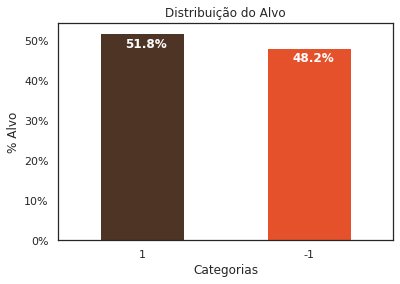

In [24]:
# Criando uma cópia do dataframe para preservar os dados originais
df1 = df.copy()

# construindo o alvo
df1 = constroi_alvo(df1, p=1)

# Criando um gráfico para verificação da distribuição do alvo
cores = ['#4D3425','#E4512B']

ax = (df1["Alvo_Bin"].value_counts(normalize=True)*100).plot(
                                        kind="bar"
                                        , stacked="true"
                                        , rot=0
                                        , color=cores)
ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Alvo')
ax.set_xlabel('Categorias')
ax.set_title('Distribuição do Alvo')

# Criando uma lista para coletar os dados plt.patches
totais = []

# encontrando os valores e anexando a lista
for i in ax.patches:
    totais.append(i.get_width())

# Confirgurando rótulos par cada barra individualmente 
total = sum(totais)

for i in ax.patches:
    # obtendo largura e altura das barras
    ax.text(i.get_x()+.15, i.get_height()-3.5, \
            str(round((i.get_height()/total), 1))+'%',
            fontsize=12,
            color='white',
            weight='bold')

### **Construindo as Variáveis**

Neste momentos serão construídas as variáveis que comporão o modelo.

In [25]:
df1 = cria_variaveis(df1)

# verificando os dados
df1.head()

,Open,High,Low,Close,Adj Close,Volume,Retorno,Alvo,Pontos,Alvo_Bin,...,cat,w,k,tau,M,g,Retorno_1,Retorno_2,zigZag,ret
Date,,,,,,,,,,,,,,,,,,,,,
2000-02-14,18083.0,18264.0,17746.0,17819.0,17819.0,0,-0.014707,0.005708,102.0,1,...,-0.000475,3.902998e-05,0.000041,-1.854003e-08,0.000087,NaN,NaN,NaN,NaN,1.000000
2000-02-15,17818.0,17932.0,17451.0,17921.0,17921.0,0,0.005708,0.010601,191.0,1,...,-0.009502,7.858812e-05,0.001986,-7.467330e-07,0.000207,NaN,-0.014707,NaN,NaN,0.020415
2000-02-16,17921.0,18247.0,17743.0,18112.0,18112.0,0,0.010601,-0.007370,-133.0,-1,...,-0.004851,-3.627507e-05,0.000331,1.759750e-07,-0.000077,NaN,0.005708,-0.014707,NaN,0.015101
2000-02-17,18116.0,18297.0,17979.0,17979.0,17979.0,0,-0.007370,-0.019886,-354.0,-1,...,-0.005360,-8.974362e-07,0.000916,4.810601e-09,0.000140,NaN,0.010601,0.005708,NaN,-0.007904
2000-02-18,17979.0,18008.0,17489.0,17625.0,17625.0,0,-0.019886,0.004246,75.0,1,...,-0.001154,-6.543668e-05,0.000148,7.548592e-08,-0.000044,0.000658,-0.007370,0.010601,NaN,-0.018444


### **Copiando o Dataframe**

---

Será criada uma cópia do dataframe excluindo algumas colunas que serviram de base para construção de variáveis.

In [26]:
# Copiando o dataframe fitrado das linhas faltantes
df2 = df1.dropna(axis=0)
df2 = df2.drop(["std5", "std10", "std15", "mm_std5", "mm_std10", "mm_std15",
                 "Retorno_1", "Retorno_2"], axis=1)

### **Tranformando as variáveis para ranges**

---

Vou transformar as variáveis e para um range fixo. Dessa forma podemos capturar padrões nos dados.

Estabeleci um valor de corte fixo, mas o ideal é que o exame do inteiro que servirá como corte seja analizado a cada variável.

In [27]:
corte = 5

# Transformando a variável zscore em categórica baseada em quantis
df2["zscore_5"] = pd.qcut(df2["zscore_5"], corte, labels=False)
df2["zscore_10"] = pd.qcut(df2["zscore_10"], corte, labels=False)
df2["zscore_15"] = pd.qcut(df2["zscore_15"], corte, labels=False)
df2["fr"] = pd.qcut(df2["fr"], corte, labels=False)
df2["ifr"] = pd.qcut(df2["ifr"], corte, labels=False)
df2["rsl_std5"] = pd.qcut(df2["rsl_std5"], corte, labels=False)
df2["rsl_std10"] = pd.qcut(df2["rsl_std10"], corte, labels=False)
df2["rsl_std15"] = pd.qcut(df2["rsl_std15"], corte, labels=False)
df2["prop"] = pd.qcut(df2["prop"], corte, labels=False)
df2["cat"] = pd.qcut(df2["cat"], corte, labels=False)
df2["v"] = pd.qcut(df2["v"], corte, labels=False)
df2["a"] = pd.qcut(df2["a"], corte, labels=False)
df2["m"] = pd.qcut(df2["m"], corte, labels=False)
df2["f"] = pd.qcut(df2["f"], corte, labels=False)
df2["t"] = pd.qcut(df2["t"], corte, labels=False)
df2["w"] = pd.qcut(df2["w"], corte, labels=False)
df2["k"] = pd.qcut(df2["k"], corte, labels=False)
df2["tau"] = pd.qcut(df2["tau"], corte, labels=False)
df2["M"] = pd.qcut(df2["M"], corte, labels=False)
df2["g"] = pd.qcut(df2["g"], corte, labels=False)
df2["cat"] = pd.qcut(df2["cat"], corte, labels=False)
df2["ret"] = pd.qcut(df2["ret"], corte, labels=False)

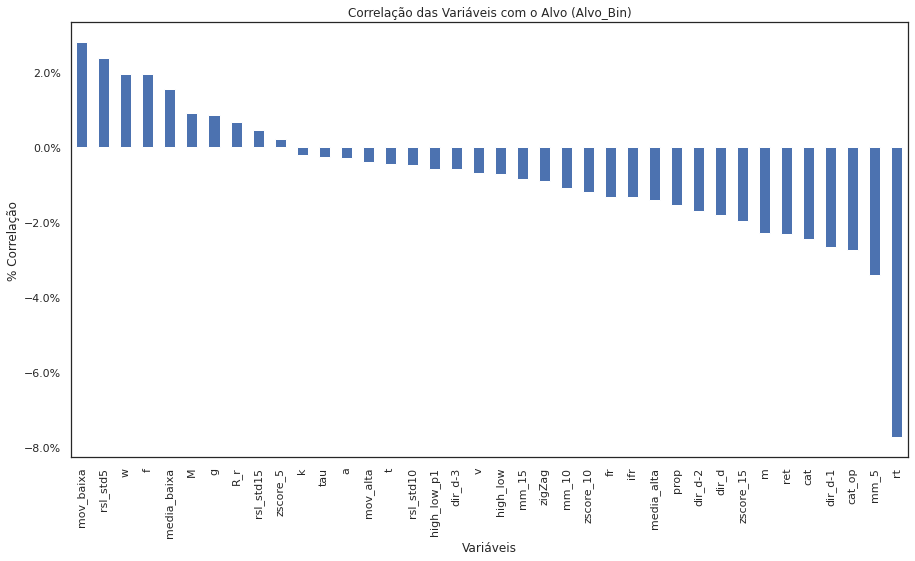

In [28]:
# Verificando a correlação entre variáveis com o Alvo_Bin
df3 = df2.drop(["Open", "High", "Low", "Close", "Adj Close", "Volume", "Alvo",
                "Pontos", "Retorno"], axis=1)

plt.figure(figsize=(15, 8))
ax = ((df3.corr()['Alvo_Bin'].sort_values(ascending=False)[1:] * 100).plot(kind='bar'))

ax.yaxis.set_major_formatter(mtick.PercentFormatter())
ax.set_ylabel('% Correlação')
ax.set_xlabel('Variáveis')
ax.set_title('Correlação das Variáveis com o Alvo (Alvo_Bin)');

### **Preparação dos Dados**

---

Separando as variáveis em treino e teste, e entre features e alvo.

In [29]:
# Separando os dados entre treinamento e teste
# Nossa base vai de 02-01-2010 a 29-10-2021

# Vamos treinar o modelo de 2010 a 2018
start_train = "2000-01-02"
end_train = "2010-12-30"

# Vamos testar o modelo de 2019 a 2021
start_test = "2011-01-02"
end_test = "2021-12-30"

# Separando os dataframes de teste e de treino
df_train = df2[start_train:end_train]
df_test = df2[start_test:end_test]

# Verificando o formato dos dados
print("df_train: {} observações - {} colunas".format(df_train.shape[0], df_train.shape[1]))
print("df_test: {} observações - {} colunas".format(df_test.shape[0], df_test.shape[1]))

# Separando as colunas que servirão como features
var_columns = df_train.columns[10:]

# Separando os dados de treino e teste com as variáveis em x e o alvo y
x_train = df_train[var_columns]
y_train = df_train["Alvo_Bin"]

x_test = df_test[var_columns]
y_test = df_test["Alvo_Bin"]

df_train: 2679 observações - 48 colunas
df_test: 2716 observações - 48 colunas


### **Treinando os Modelos**

---

In [30]:
modelos = [LogisticRegression(random_state=42),
           SGDClassifier(random_state=42),
           DecisionTreeClassifier(criterion="gini", max_depth=6, random_state=42),
           XGBClassifier(random_state=42)]
for i, modelo in enumerate(modelos):
    mod = modelo.fit(x_train, y_train)
    y_pred_train  = mod.predict(x_train)
    y_pred_test  = mod.predict(x_test)
    print("Emod{}  - Treino: {} - Test: {}".format(i, round(metrics.accuracy_score(y_train, y_pred_train)* 100, 2),
                                                   round(metrics.accuracy_score(y_test, y_pred_test)* 100, 2)))

Emod0  - Treino: 56.03 - Test: 51.4
Emod1  - Treino: 51.96 - Test: 51.25
Emod2  - Treino: 58.98 - Test: 48.82
[10:37:55] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Emod3  - Treino: 99.96 - Test: 50.37


### **Treinamento do Ensemble**

---

In [31]:
modelos = [
          ("Emod0", LogisticRegression(random_state=42)),
           ("Emod1", SGDClassifier(random_state=42)),
          ("Emod2", DecisionTreeClassifier(criterion="gini", max_depth=6, random_state=42)),
           ("Emod3", XGBClassifier(random_state=42))
]

e_multi = StackingClassifier(modelos, final_estimator=XGBClassifier(max_depth=1
                                                                    , colsample_bytree=0.1
                                                                    , gamma=2
                                                                    , random_state=42),
                             passthrough=True).fit(x_train, y_train)

# Predizendo para os dados de treino e teste
y_pred_train_e_multi = e_multi.predict(x_train)
y_pred_test_e_multi = e_multi.predict(x_test)

#Acurácia
print("e_multi (Acurácia) - Treino: {} | Teste: {}".format(round(metrics.accuracy_score(y_train, y_pred_train_e_multi)* 100, 2),
                                                        round(metrics.accuracy_score(y_test, y_pred_test_e_multi)* 100, 2)))

[10:38:13] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:16] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[10:38:17] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old be

##**Avaliação dos Resultados e análise de robustez**

---

#### **Matriz de Confusão**

In [32]:
print(confusion_matrix(y_test, y_pred_test_e_multi))
print()
print("----------------------------------------------------------")
print()
print(classification_report(y_test, y_pred_test_e_multi))
print("----------------------------------------------------------")

[[ 199 1133]
 [ 212 1172]]

----------------------------------------------------------

              precision    recall  f1-score   support

          -1       0.48      0.15      0.23      1332
           1       0.51      0.85      0.64      1384

    accuracy                           0.50      2716
   macro avg       0.50      0.50      0.43      2716
weighted avg       0.50      0.50      0.44      2716

----------------------------------------------------------


#### **Calculando a performance do modelo**

""


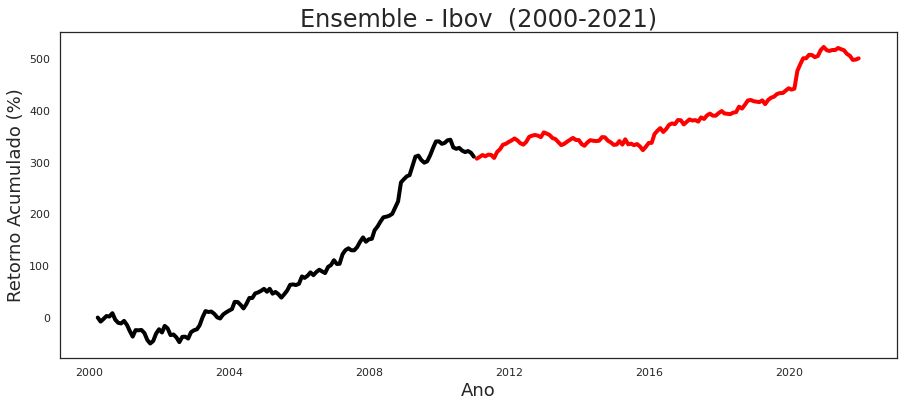

In [33]:
y_pred_all = e_multi.predict(df2[var_columns])

# Calculando a performance
df2.loc[:, "Previsto"] = y_pred_all

# Convertendo para float
df2.loc[:, "Retorno_Modelo"] = df2.loc[:, "Previsto"] *  df2["Alvo"]

# Criando um stop de 2,5%
stop = 0.025
df2.loc[:, "Retorno_Modelo"] = np.where(
                                    df2.loc[:, "Retorno_Modelo"] < -stop, -stop,
                                    df2.loc[:, "Retorno_Modelo"]
)

# Criando configurações para fazer um conditional plot
df2.index.name = "Data"
df2.reset_index(inplace=True)
df2["Data"] = pd.to_datetime(df2["Data"])
df2["train_test"] = np.where(df2["Data"] > end_train, 1, -1)

# Criando um resample para reunir os dados por mês
base_agregada = df2.resample("M", on="Data").sum()
# Calculando o resultado acumulado por mês
base_agregada.loc[:, "Retorno_Modelo_Acumulado"] = base_agregada["Retorno_Modelo"].cumsum() * 100

# Plota gráfico
fig, ax = plt.subplots(figsize=(15,6))
def grafico(group):
    color = "black" if (group["train_test"] < 0).all() else "red"
    lw = 4.0
    ax.plot(group.index, group.Retorno_Modelo_Acumulado, c=color, linewidth=lw)
    plt.xlabel("Ano", fontsize=18);
    plt.ylabel("Retorno Acumulado (%)", fontsize=18);
    plt.title("Ensemble - Ibov  (2000-2021)", fontsize=24)
    setup = dict(size=16, color='darkgreen')
    setup2 = dict(size=14, color="black")

base_agregada.groupby((base_agregada["train_test"].shift() * base_agregada["train_test"] < 0).cumsum()).apply(grafico)

#### **Resumo do Histórico**


In [34]:
# Resumo histórico ano
summary = df2.copy()
summary["Data"] = pd.to_datetime(summary["Data"], format="%Y-%m")
summary = summary.groupby([summary["Data"].dt.year]).agg({"Retorno_Modelo": sum})
summary.index = summary.index.set_names(["Ano"])

# Resumo histórico mês
summary_mes = df2.copy()
summary_mes["Data"] = pd.to_datetime(summary_mes["Data"], format="%Y-%m")
summary_mes = summary_mes.groupby([summary_mes["Data"].dt.year, summary_mes["Data"].dt.month]).agg({"Retorno_Modelo": sum})
summary_mes.index = summary_mes.index.set_names(["Ano", "Mes"])

print("--- OMNP: Resultado Ensemble IBOV de 2000 a 2021 ---")
print()
print("Treinamento: 2000-2010")
print("Teste: 2011-2021")
print("Stop de 2,5% - custos operacionais não incluídos")
print("----------------------------------------------------")
print()
print("Pior retorno mensal: {}%".format(round(summary_mes["Retorno_Modelo"].min(), 3)*100))
print("Melhor retorno mensal: {}%".format(round(summary_mes["Retorno_Modelo"].max(), 2)*100))
print("Média de ganho mensal : {}%".format(round(summary_mes["Retorno_Modelo"].mean(), 2)*100))
print("----------------------------------------------------")
print()
print("Pior retorno anual: {}%".format(round(summary["Retorno_Modelo"].min(), 3)*100))
print("Melhor retorno anual: {}%".format(round(summary["Retorno_Modelo"].max(), 2)*100))
print("Média de ganho anual: {}%".format(round(summary["Retorno_Modelo"].mean(), 2)*100))
print("----------------------------------------------------")
print()
print("Meses positivos: {}".format((summary_mes["Retorno_Modelo"] > 0).sum()))
print("Meses negativos: {}".format((summary_mes["Retorno_Modelo"] < 0).sum()))
print("----------------------------------------------------")
print()
print("Anos positivos: {}".format((summary["Retorno_Modelo"] > 0).sum()))
print("Anos negativos: {}".format((summary["Retorno_Modelo"] < 0).sum()))
print("----------------------------------------------------")
print()
print("Total(simples): {}%".format(round(summary_mes["Retorno_Modelo"].sum(), 3)*100))

--- OMNP: Resultado Ensemble IBOV de 2000 a 2021 ---

Treinamento: 2000-2010
Teste: 2011-2021
Stop de 2,5% - custos operacionais não incluídos
----------------------------------------------------

Pior retorno mensal: -14.899999999999999%
Melhor retorno mensal: 36.0%
Média de ganho mensal : 2.0%
----------------------------------------------------

Pior retorno anual: -29.599999999999998%
Melhor retorno anual: 115.99999999999999%
Média de ganho anual: 23.0%
----------------------------------------------------

Meses positivos: 156
Meses negativos: 106
----------------------------------------------------

Anos positivos: 15
Anos negativos: 7
----------------------------------------------------

Total(simples): 500.8%
